In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astropy.visualization import make_lupton_rgb

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, FullCatalog

In [2]:
with initialize(config_path="./ynet_diffusion_config", version_base=None):
    new_diffusion_notebook_cfg = compose("ynet_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [4]:
one_batch = None
image_index = None
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_full_cat = TileCatalog(batch["tile_catalog"]).to_full_catalog(tile_slen)
    batch_plocs = batch_full_cat["plocs"]
    batch_plocs_mask = ((batch_plocs < 76.0) & (batch_plocs > 4.0)).all(dim=-1)
    batch_plocs_count = batch_plocs_mask.sum(dim=-1)
    if (batch_plocs_count >= 10).any():
        one_batch = batch
        image_index = (batch_plocs_count >= 10).nonzero()[0].item()
        break

  0%|          | 0/196 [00:04<?, ?it/s]


In [5]:
image_tile_cat = TileCatalog(one_batch["tile_catalog"])
image_full_cat = image_tile_cat.to_full_catalog(tile_slen)

In [6]:
image_plocs = image_full_cat["plocs"][image_index, :image_full_cat["n_sources"][image_index]]
image_plocs_mask = ((image_plocs < 76.0) & (image_plocs > 4.0)).all(dim=1)
image_plocs_mask &= ~(image_full_cat["bbox_hw"][image_index, :image_full_cat["n_sources"][image_index]].isnan().any(dim=1))
image_plocs = image_plocs[image_plocs_mask]
assert image_plocs.shape[0] > 0

In [7]:
image_point_bbox = image_full_cat["bbox_hw"][image_index, :image_full_cat["n_sources"][image_index]]
image_point_bbox = image_point_bbox[image_plocs_mask]
image_point_bbox = torch.cat([image_plocs, image_point_bbox], dim=-1)

In [8]:
def create_rgb(image, bgr=[1, 2, 3], stretch=1, Q=10, scale=None):
    if scale is None:
        r_im = image[bgr[2]]  # for the r channel
        g_im = image[bgr[1]]  # for the g channel
        b_im = image[bgr[0]]  # for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]] * scale[0]
        g_im = image[bgr[1]] * scale[1]
        b_im = image[bgr[0]] * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

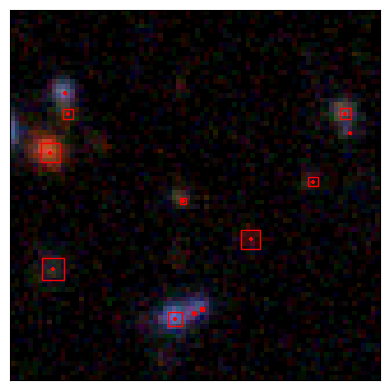

In [9]:
image = one_batch["images"][image_index]
rgb_image = create_rgb(image, scale=[0.6, 0.7, 1.0], stretch=0.5, Q=2)

line_width = 1.0
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(rgb_image)
# for x in range(0, 80, 4):
#     ax.axvline(x=x - 0.5, color="white", linewidth=line_width)
# for y in range(0, 80, 4):
#     plt.axhline(y=y - 0.5, color="white", linewidth=line_width)


# for point in image_plocs:
#     circle = plt.Circle((point[1], point[0]), radius=3, edgecolor=None, facecolor="yellow", alpha=0.4)
#     ax.add_patch(circle)
ax.scatter(image_plocs[:, 1], image_plocs[:, 0], color="red", marker="+", s=10)
for (y, x, h, w) in image_point_bbox:
    rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

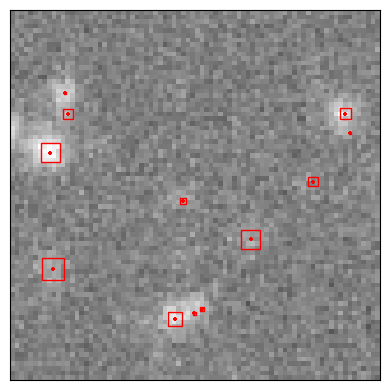

In [10]:
image = one_batch["images"][image_index]
image = ((image + 0.5).norm(dim=0, p=1) / 6).clamp(min=0, max=1)
image = (image * 255).clamp(min=0, max=255)

line_width = 1.0
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray", vmin=0, vmax=255)
# for x in range(0, 80, 4):
#     ax.axvline(x=x - 0.5, color="white", linewidth=line_width)
# for y in range(0, 80, 4):
#     plt.axhline(y=y - 0.5, color="white", linewidth=line_width)


# for point in image_plocs:
#     circle = plt.Circle((point[1], point[0]), radius=3, edgecolor=None, facecolor="yellow", alpha=0.4)
#     ax.add_patch(circle)
ax.scatter(image_plocs[:, 1], image_plocs[:, 0], color="red", marker="+", s=10)
for (y, x, h, w) in image_point_bbox:
    rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

samples: 30427; 0.0018100535395597858; 11.58434265318263
samples: 29116; 0.001732064247471743; 11.085211183819155
samples: 29965; 0.0017825698988697203; 11.40844735276621
samples: 27692; 0.0016473527662105888; 10.543057703747769


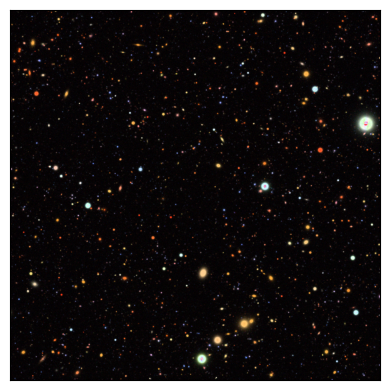

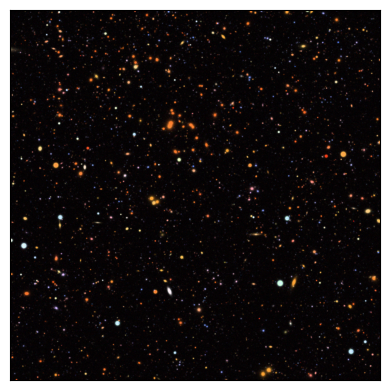

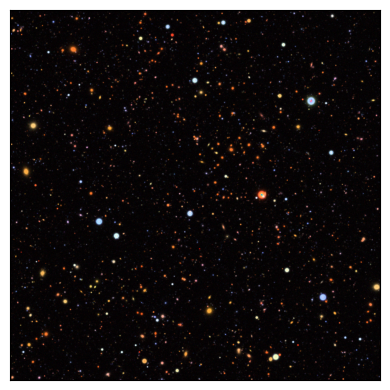

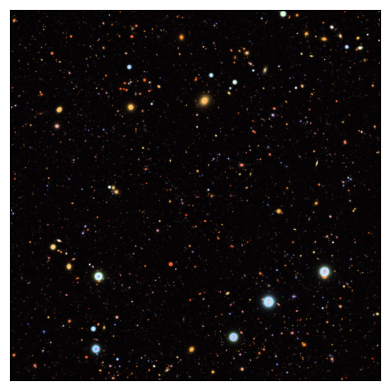

In [15]:
for i in range(4):
    plotting_sample = dc2.get_plotting_sample(i)
    n_sources = plotting_sample["tile_catalog"]["n_sources"].sum().item()
    print(f"samples: {n_sources}; {n_sources / (4100 ** 2)}; {n_sources / (4100 ** 2) * (80 ** 2)}")
    image = plotting_sample["image"][:, :2000, :2000]
    rgb_image = create_rgb(image, scale=[0.6, 0.7, 1.0], stretch=0.5, Q=2)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(rgb_image)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(f"./full_image_{i}.png", dpi=300)
    fig.show()